# C. Linear bias correction

Generally, seasonal forecast is produced for coarse grid resolutions, which can lead to systematic errors or bias. Therefore, bias correction is a recommended practice, particularly when the catchment size is of similar size or smaller than the grid scale (Crochemore et al., 2016).

This code generates bias corrected data by multiplying (adding) daily precipitation (temperature) bias correction factors (ratio of past observed data and seasonal forecast data).

### 1. Import Libraries

Let's start by importing the necessary libraries (🚨 in order to run the code like in the cell below, place the mouse pointer in the cell, then click on “run cell” button above or press shift + enter).

In [7]:
import glob
import pandas as pd
import numpy as np
import openpyxl
from openpyxl import load_workbook
from openpyxl import Workbook
import matplotlib as mpl
import matplotlib.pylab as plt
import datetime
import seaborn as sns
from pandas import Series, DataFrame
from matplotlib import font_manager, rc
import matplotlib.dates as mdates
from IPython.core.display import display, HTML

display(HTML("<style>.container{width:90% !important;}</style>"))

### 2. Basic settings

Before we start to apply linear bias correction, you need to specify some basic information;

In [10]:
originating_centre = 'ECMWF'
variable = 'tp'               # Information that you want to calculate areal mean
catch_name = 'A'             # What is the name of your catchment?
start_month = 1                  # Download start month
end_month = 12                 # Download end month
days = {1:31,2:28,3:31,4:30, 5:31, 6:30, 7:31, 8:31, 9:30, 10:31, 11:30,12:31}

inpath = './assessment/' + str(originating_centre.upper())+ '/daily/'
bcpath = './assessment/' + str(originating_centre.upper())+ '/biascorrection/'

### 3. Mean value extraction

Bias correction is based on the average difference between monthly observed data and historical simulated data of climate models over the same period of the observed data.The linear scaling approach, which is simple and still often can bring similar results to more sophisticated methods, is applied to generate bias corrected data.

Linear bias correction can be expressed simply as (Here, we use precipitation as an example)


$$ P_{forecasted}^* = P_{forecasted}·[\frac{{μ_m (P_{observed})}}{{μ_m (P_{forecasted})}}  ]	$$


where $P_{forecasted}^*$ is a bias corrected forecasted precipitation (daily), $P_{forecasted}$ is forecasted precipitation (daily) before bias correction, $μ_m$ is monthly mean, and $P_{observed}$ represents observed precipitation (daily)


As shown in the equation above, linear bias correction basically compares the mean value of ensemble members to observed value, thus, we need to extract mean values first.

In [12]:
start_year = 1993              # bias correction factor calculation start year
end_year = 2010                # bias correction factor calculation end year

for years in range(start_year,end_year+1):
    for months in range(start_month,end_month+1):
        # Call input data
        df = pd.read_csv(inpath + str(catch_name) + '_' + str(years) + '_' + str(months).zfill(2) + '_' + str(originating_centre.lower())+ '_' + str(variable) + '.csv')
        # time and mean columns collection
        condition = (df.leadtime == 1)
        temp = df.loc[condition,['date', 'mean']]
        if years == start_year and months ==start_month:
            temp1 = temp
        else :
            pass
        temp1 = temp1.append(temp, ignore_index = True)

# Stack data right side
temp2 = temp1[days[start_month]:]
temp2.set_index('date', inplace=True)
# Save the extracted mean values as csv
temp2.to_csv(bcpath + str(catch_name) + '_mean.csv')
print("Successful")

Successful


### 4. Bias correction factor calculation

Previous studies suggest that the additive correction is preferable for temperature whereas multiplicative correction is preferable to variables such as precipitation, vapor pressure, solar radiation etc. (Shrestha et al., 2016). 

Thus, bias correction factors are the ratio (or difference) between mean observed data and mean forecasted data.
In this example, we use precipitation data, so the ratio can be calculated as the ratio. 

However, if you choose the variable as 't2m' which is temperature, this code will calculate the factors as a difference.

In [47]:
# Call observed data for bias correction
df_obs = pd.read_csv('./assessment/obsdata_tp.csv')

# Call previously extracted mean value data
df_mean = pd.read_csv(bcpath + str(catch_name) + '_mean.csv')

# Calculation of bias correction factors
empty_df = pd.DataFrame()
empty_df['date'] = pd.to_datetime(df_mean['date'])
empty_df['month'] = empty_df['date'].dt.month
empty_df['obs'] = df_obs[catch_name]
empty_df['fore'] = df_mean['mean']
bc_factor = empty_df.groupby('month').mean()
if variable == 't2m':
    bc_factor['factor'] = bc_factor['obs'] - bc_factor['fore']
elif variable == 'tp' or 'e':
    bc_factor['factor'] = bc_factor['obs']/bc_factor['fore']
# Save the generated bias correction factor as csv
bc_factor.to_csv(bcpath + '[bc_factor] ' + str(catch_name) + '.csv')

print("Successful")

Successful


### 5. Bias corrected Time-series generation

Now, each time-series data will be bias corrected using bias correction factor. It will take around 1 minute to complete this code. 
This example uses multiplicative bias correction method to correct bias for precipitation. And it is easy to revise, see the annotation below.

Normally, we need as many data as possible, hence, the period for bias correction factor calculation is longer than its application. 
In this example, we have calculated bias correction factor using 17 years from 1994 to 2010 already, and now that factor will be applied to recently generated seasonal forecasts time series from 2011 to 2020.

This code activate the calculation between bias correction factors and time-series datasets.

In [50]:
# Period that you want to apply linear bias correction
bc_start_year = 2011                # Data bias correction start year
bc_end_year = 2020                # Data bias correction end year

# Call previously generated bias correction factor
bc_factor = pd.read_csv(bcpath + '[bc_factor] ' + str(catch_name) + '.csv')
for years in range(bc_start_year,bc_end_year+1):
    for months in range(start_month,end_month+1):
        # Call input data
        df = pd.read_csv(inpath + str(catch_name) + '_' + str(years) + '_' + str(months).zfill(2) + '_' + str(originating_centre.lower())+ '_' + str(variable) + '.csv')
        # Apply bias correction factor to individual datasets
        ens_num = df.shape[1]-4
        df['date'] = pd.to_datetime(df['date'])
        df['month'] = df['date'].dt.month
        df = pd.merge(df, bc_factor.loc[:,['month','factor']], on = 'month')
        if variable == 't2m':
            for i in range(0,ens_num):
                df['sc_'+str(i)] = round(df['sc_'+str(i)] + df['factor'],2)
        elif variable == 'tp' or 'e':
            for i in range(0,ens_num):
                df['sc_'+str(i)] = round(df['sc_'+str(i)]*df['factor'],2)
        df = df.drop(columns = ['mean', 'month', 'factor'])
        df['mean'] = round(df.iloc[:,2:ens_num+2].mean(axis=1),2)
        df.set_index('date', inplace=True)
        # Save bias corrected datasets as csv
        df.to_csv(bcpath + str(catch_name) + '_' + str(years) + '_' + str(months).zfill(2) + '_' + str(originating_centre.lower())+ '_' + str(variable) + '_bc.csv')
print("Successful")

Successful


### 6. Drawing figures

You also may want to draw graphs after bias correction. This code help you to create multiple graphs after the bias correction.

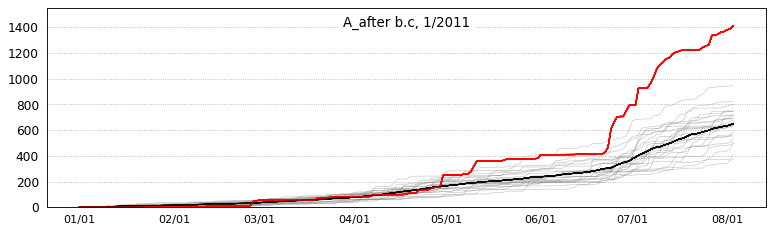

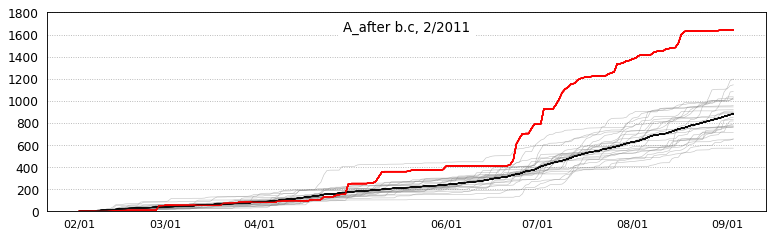

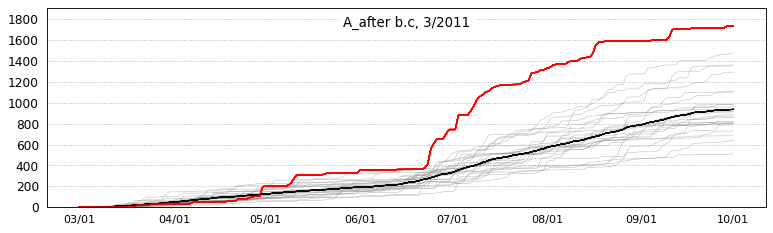

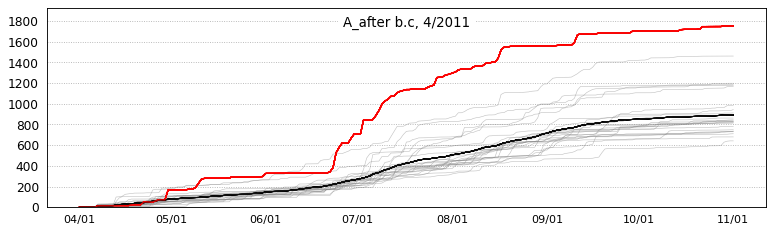

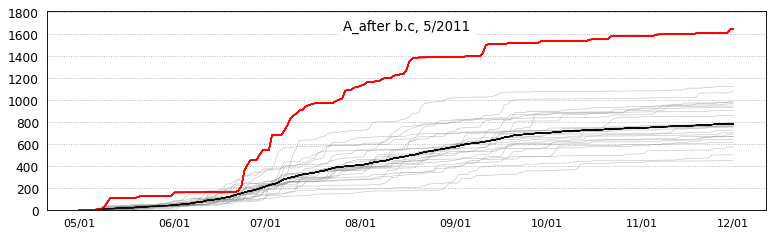

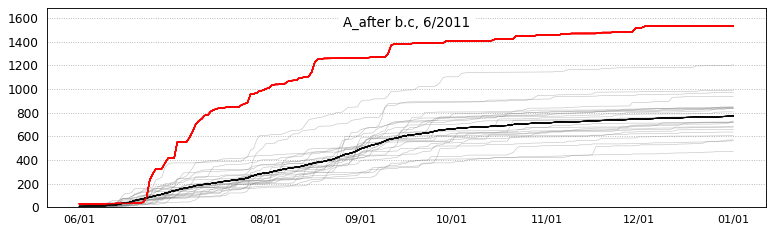

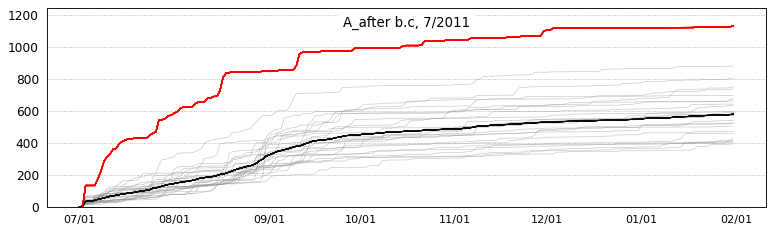

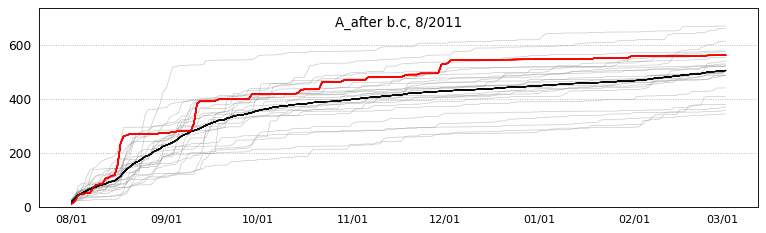

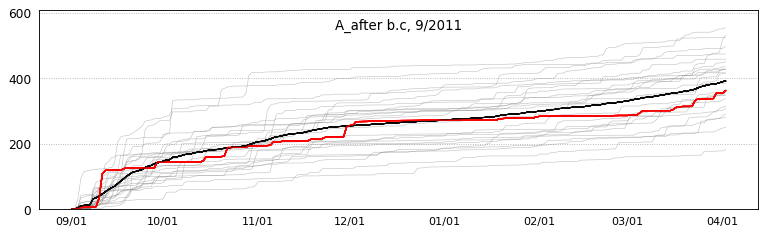

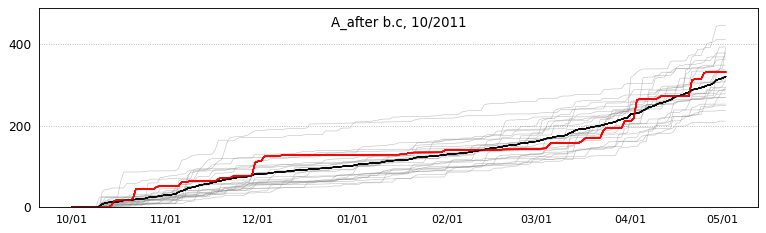

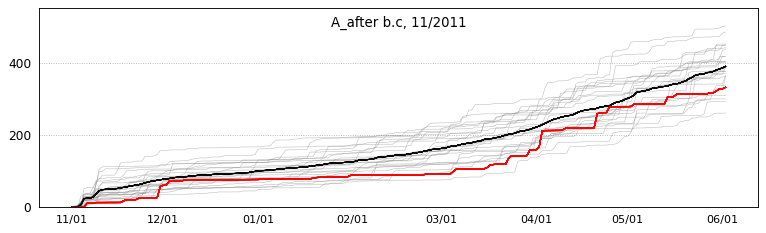

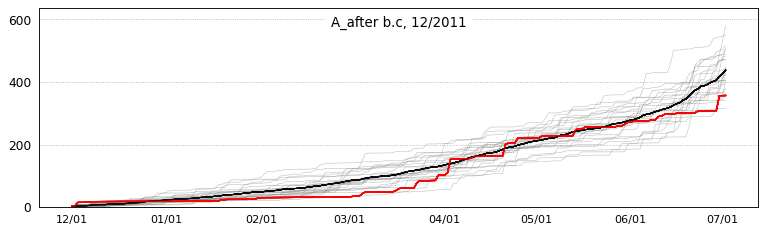

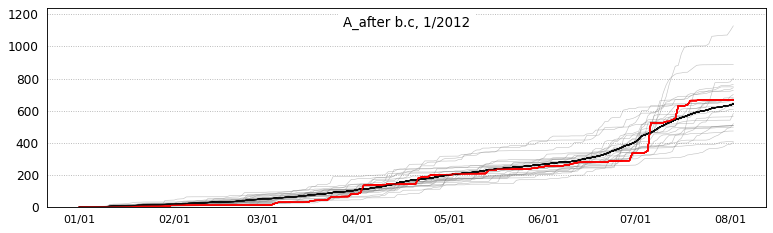

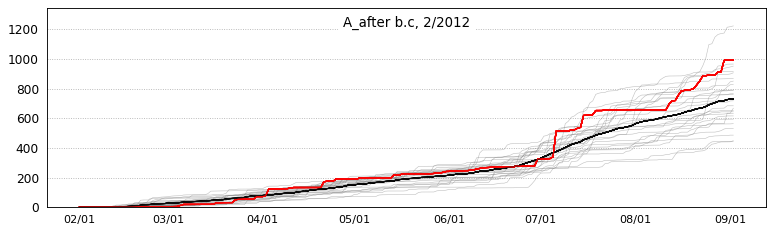

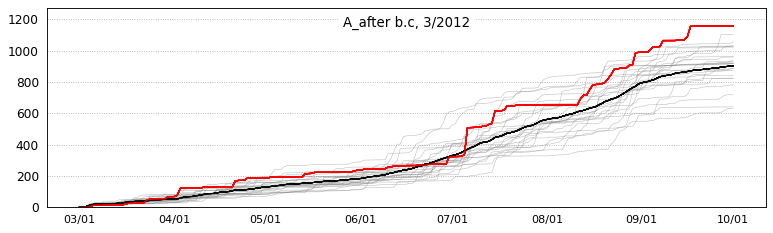

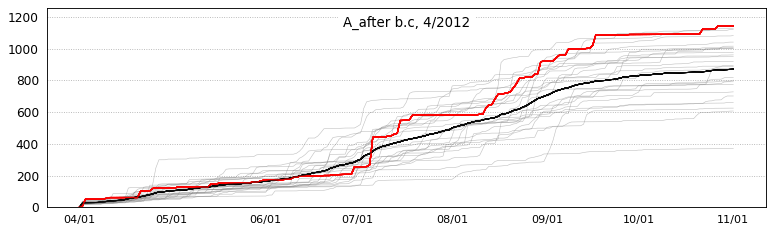

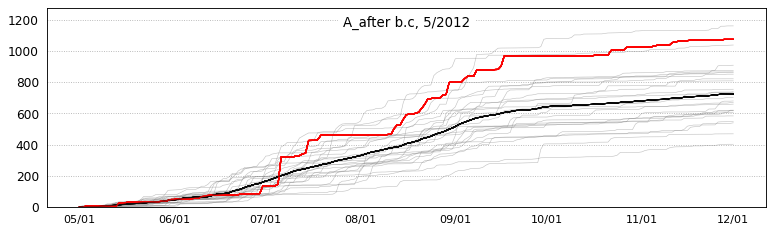

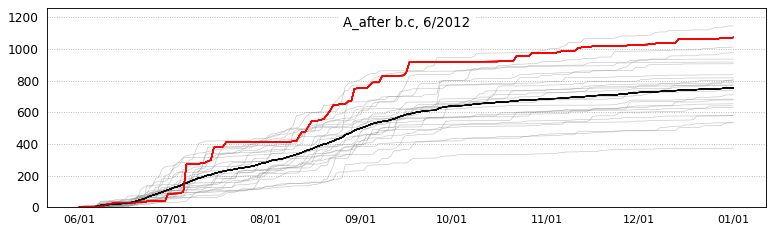

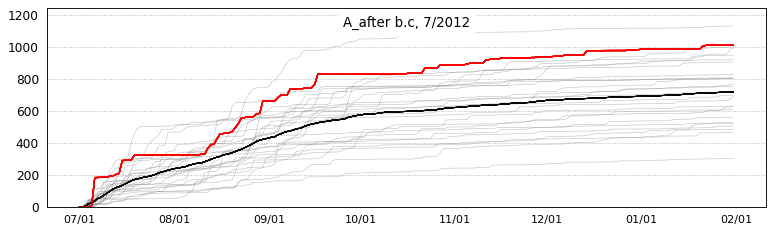

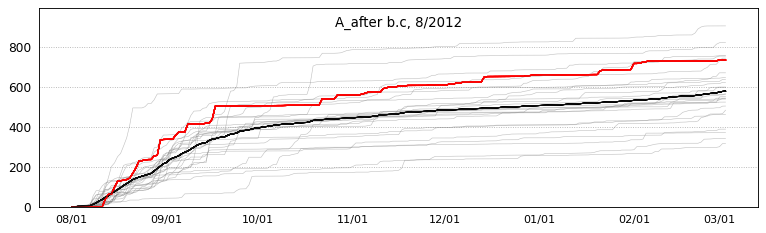

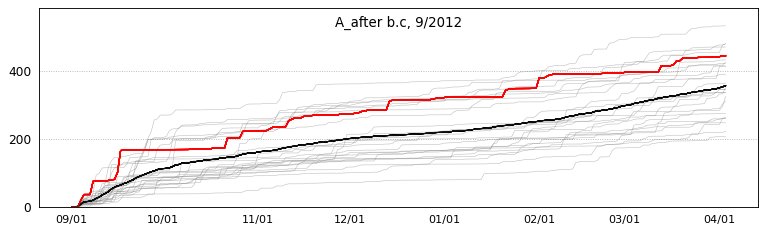

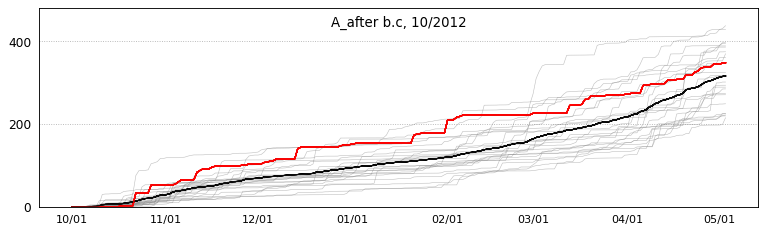

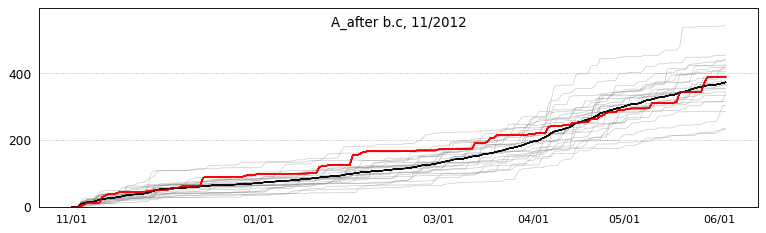

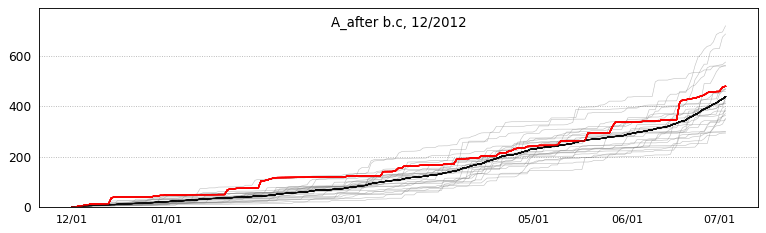

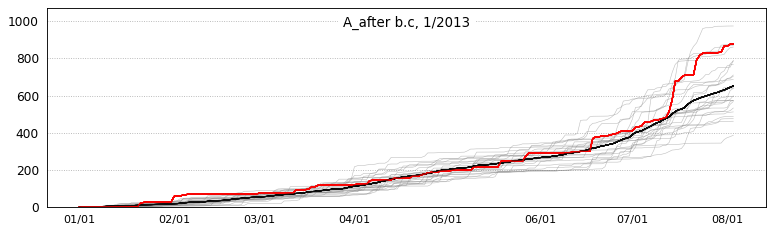

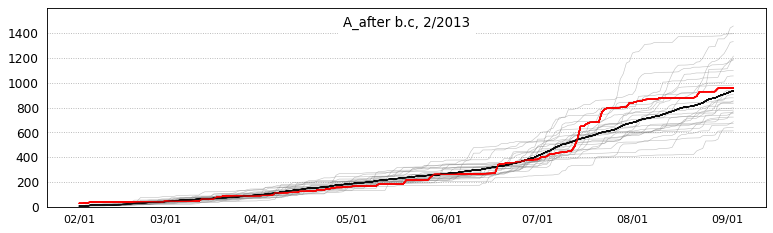

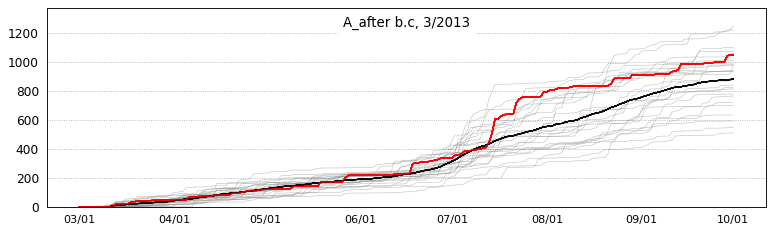

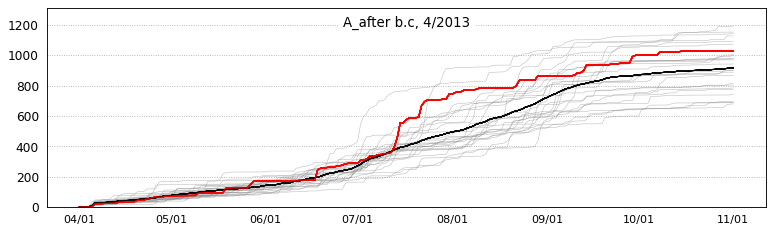

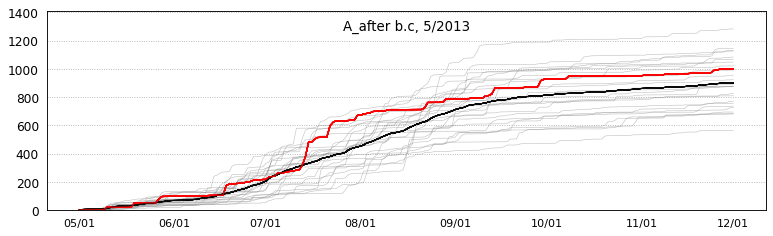

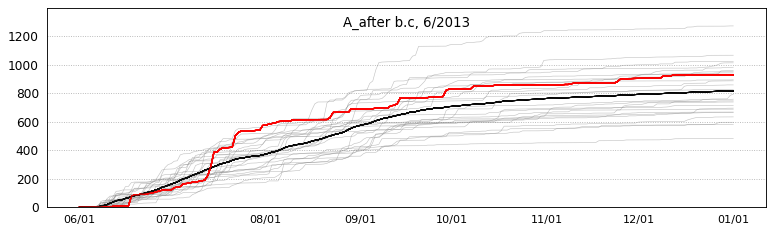

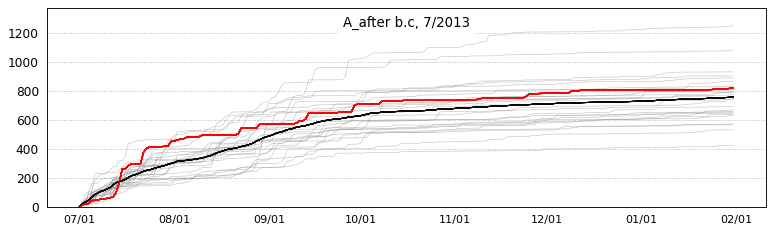

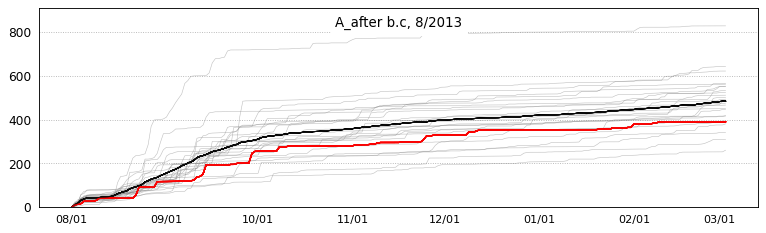

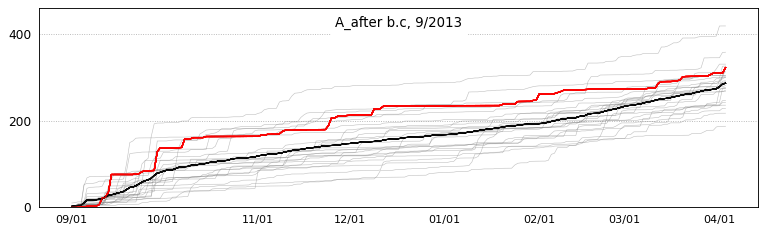

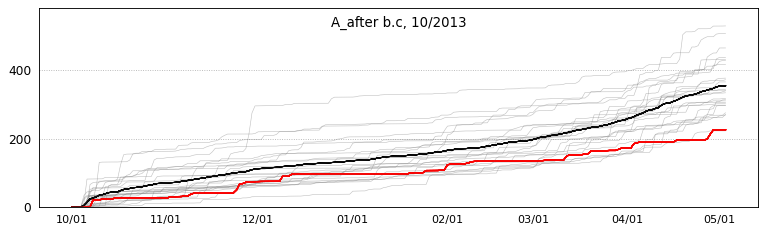

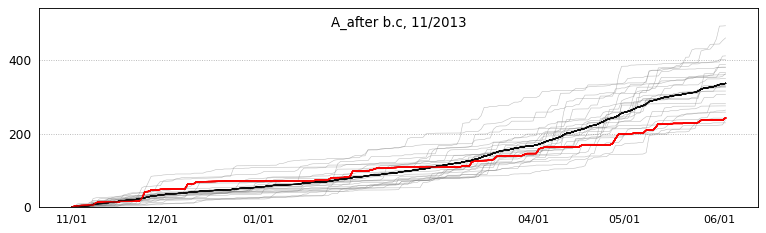

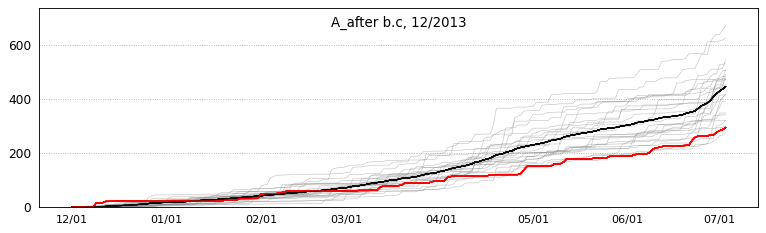

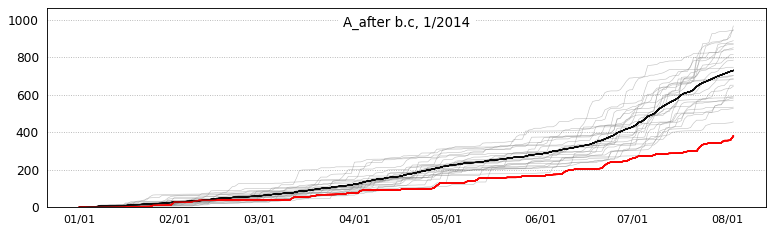

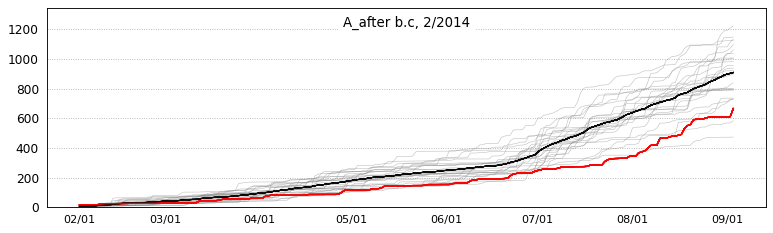

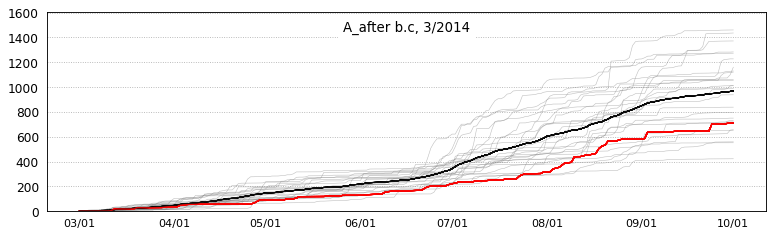

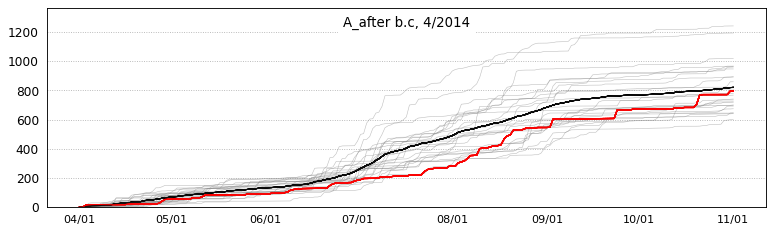

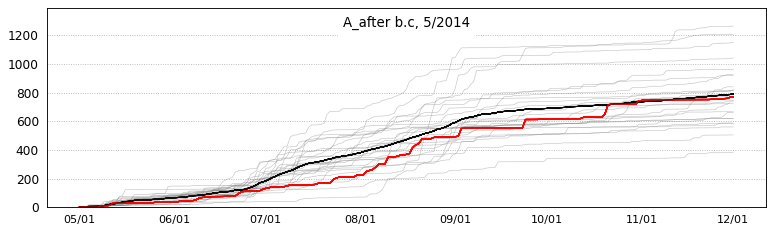

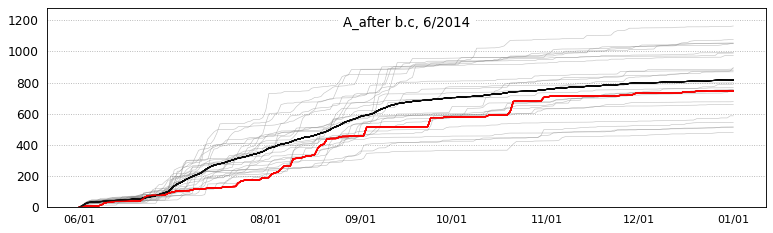

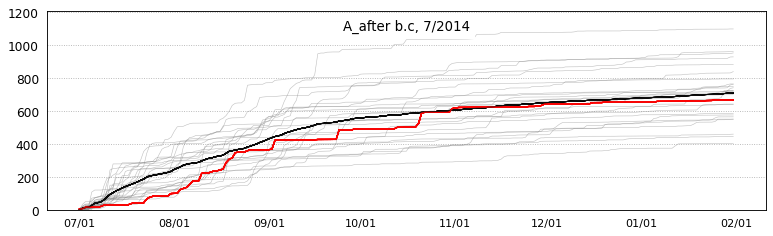

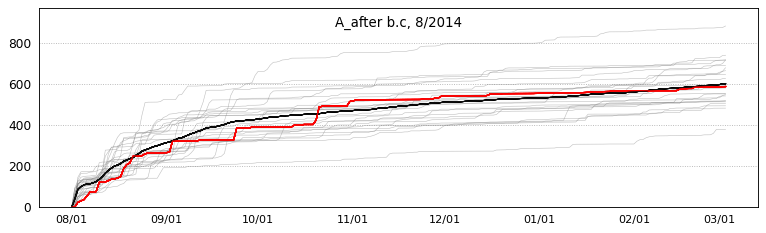

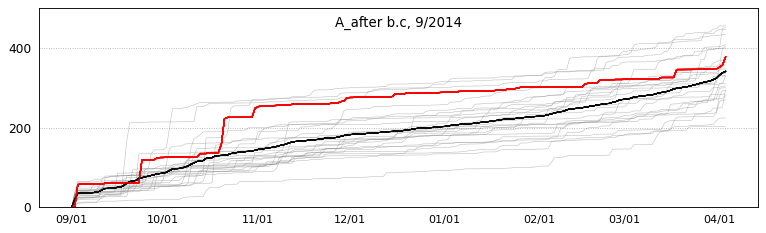

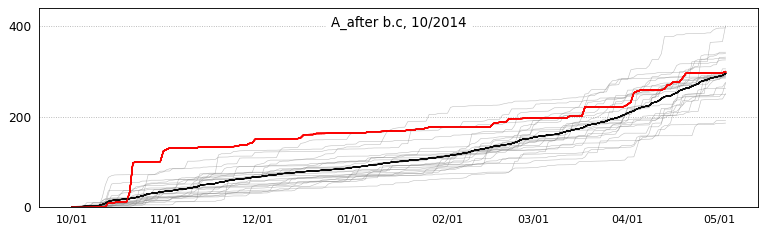

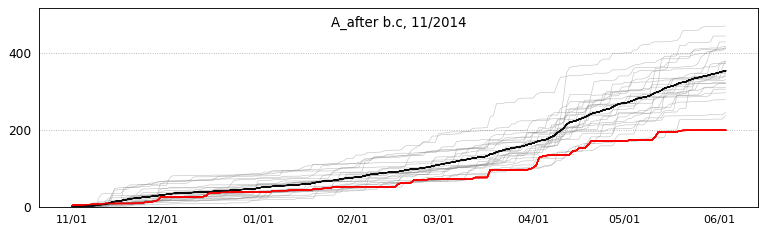

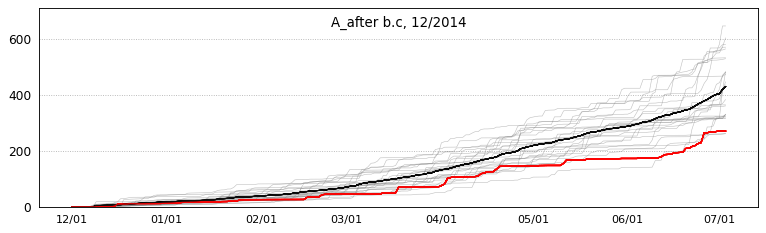

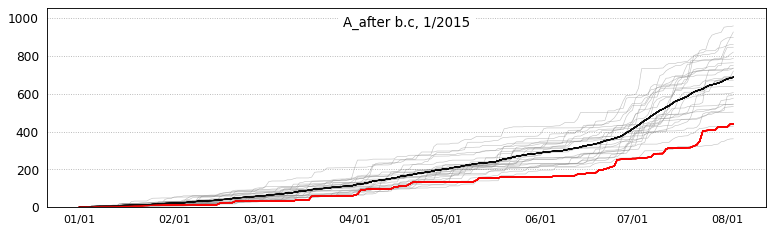

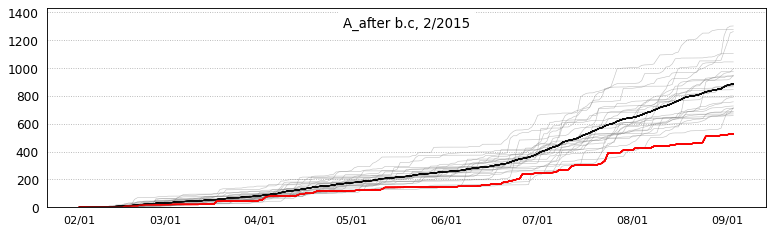

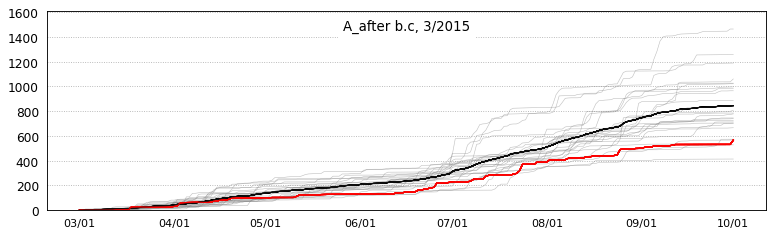

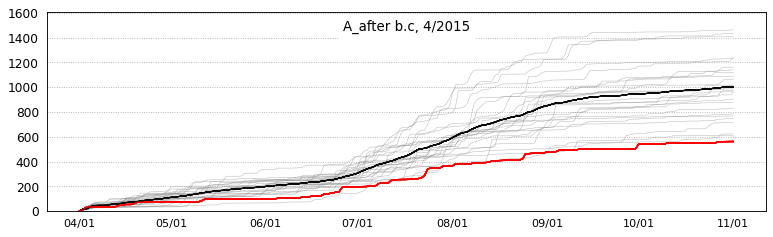

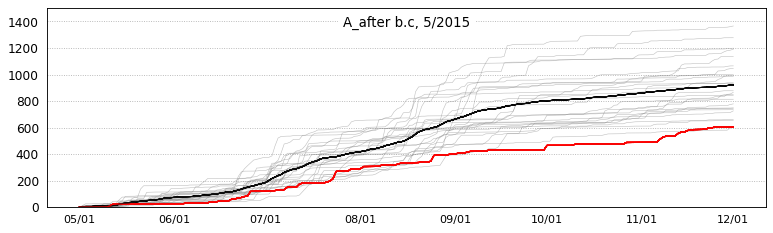

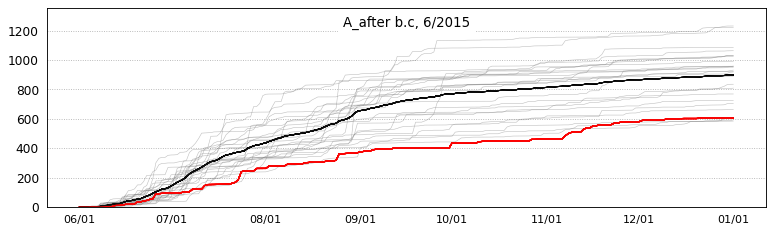

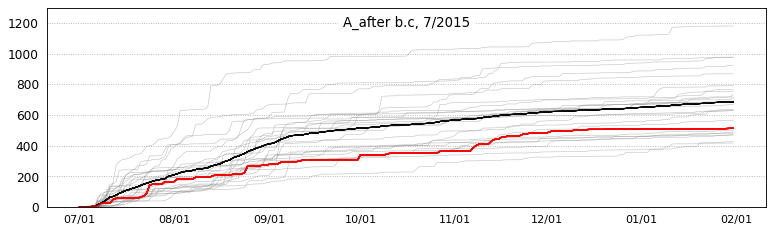

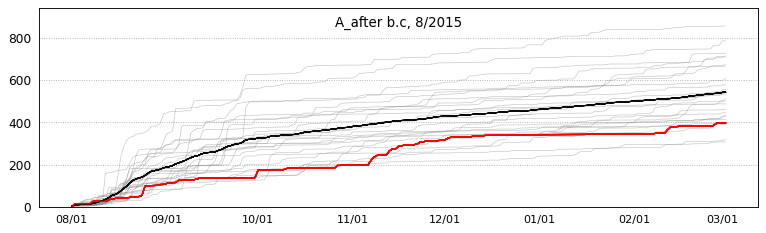

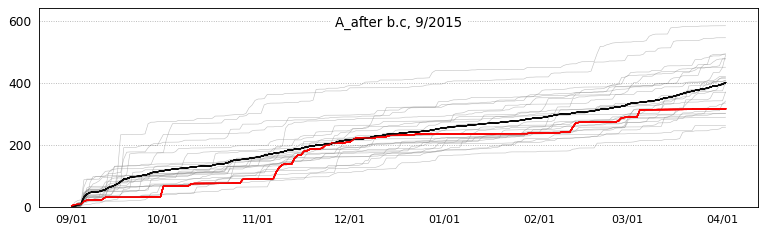

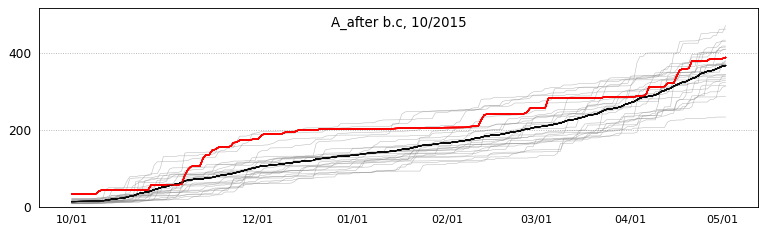

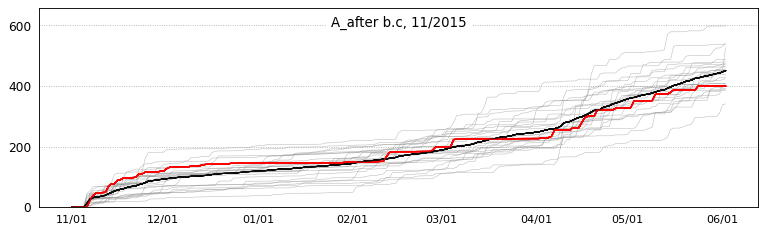

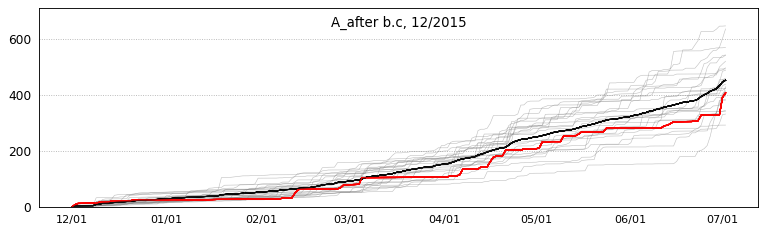

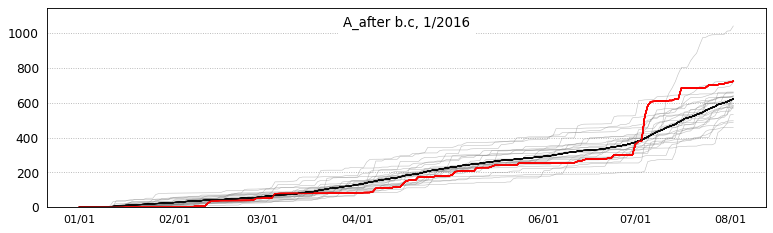

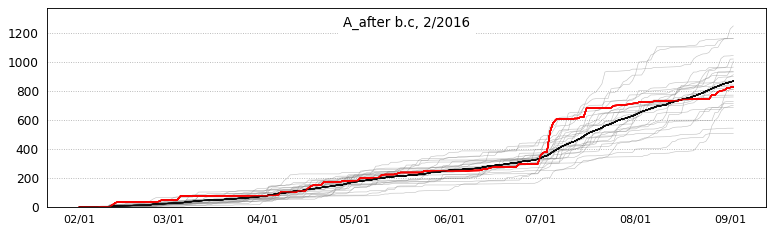

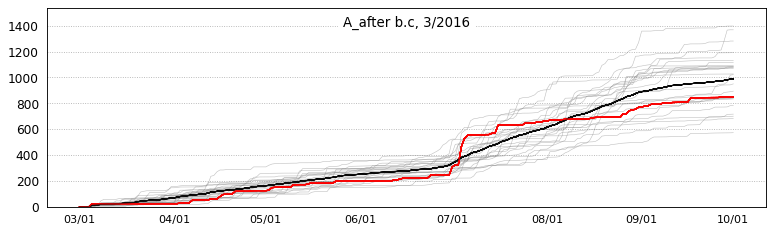

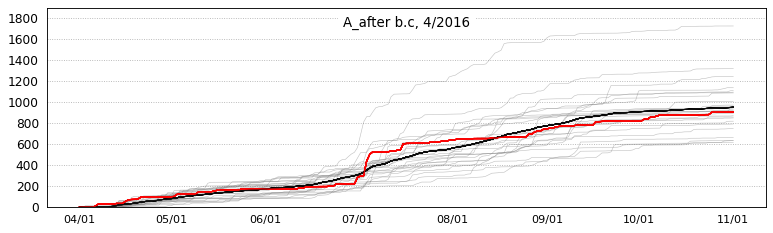

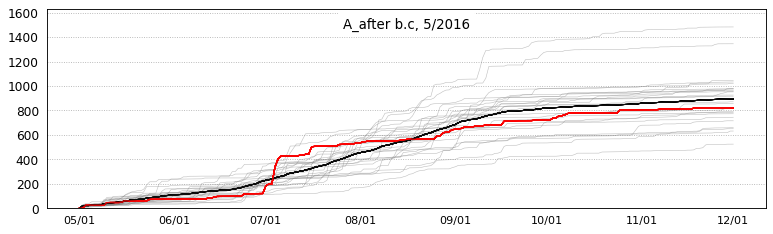

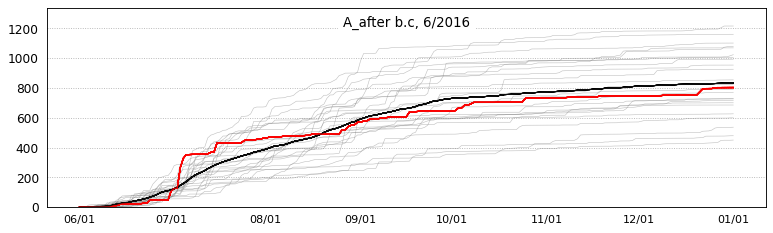

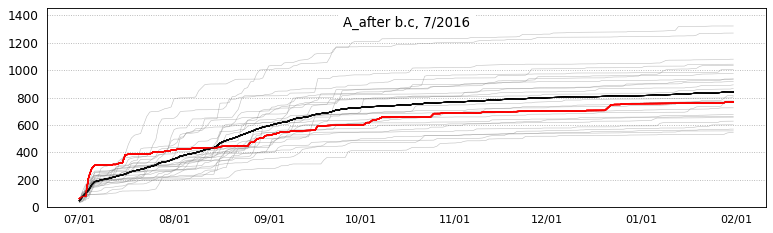

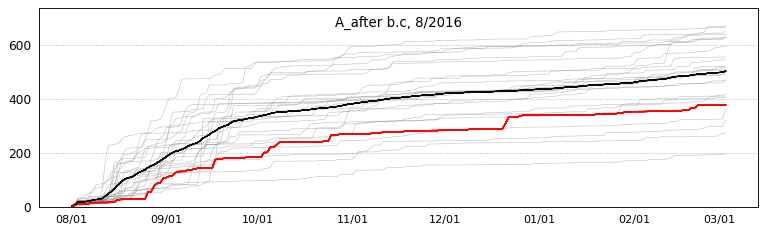

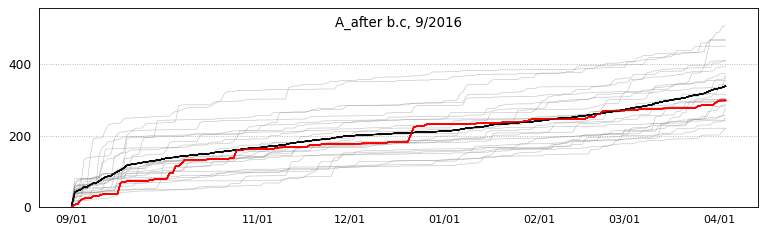

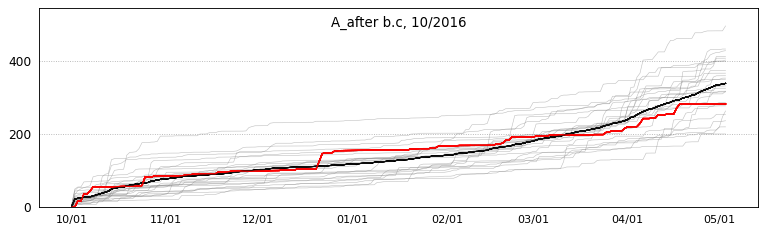

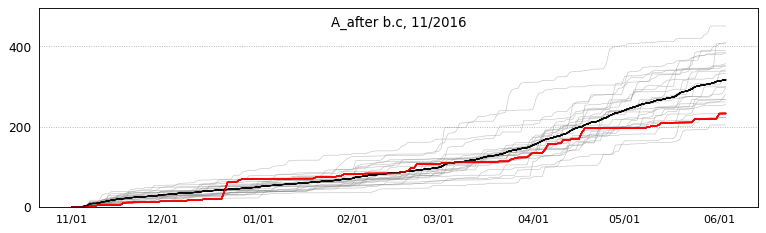

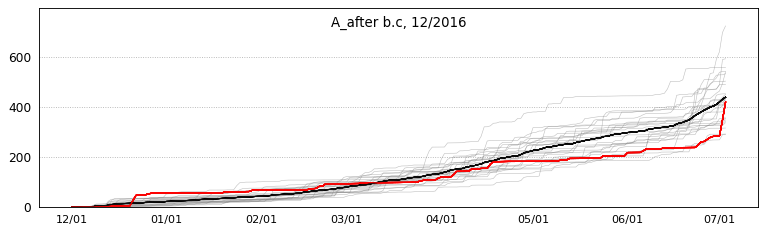

IndexError: list index out of range

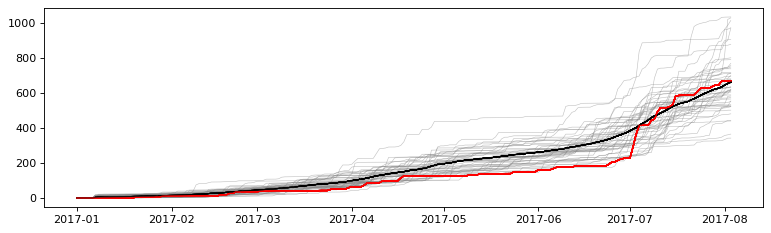

In [52]:
# Period that you want to apply linear bias correction
graph_start_year = 2011                # Data bias correction start year
graph_end_year   = 2020                  # Data bias correction end year

for years in range(graph_start_year,graph_end_year+1):
    
    for months in range(start_month,end_month+1):
        
        # Call input data
        path = bcpath + str(catch_name) + '_' + str(years) + '_' + str(months).zfill(2) + '_' + str(originating_centre.lower())+ '_' + str(variable) + '_bc.csv'
        df = pd.read_csv(path)
        df.drop(['leadtime'], axis=1, inplace=True)        
        df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True, format='%m/%d/%Y', errors='ignore')

        # Define the boundary and colors of graph
        y_LL = 0
        y_UL = int(np.cumsum(df.iloc[:, 1:]).max().max()*1.1)
        y_interval = 200
        mycolors = ['tab:grey', 'tab:grey', 'tab:grey', 'tab:grey', 'tab:grey', 'tab:grey', 'tab:grey', 'tab:grey', 'tab:grey', 'tab:grey', 'tab:grey', 'tab:grey', 'tab:grey', 'tab:grey', 'tab:grey', 'tab:grey', 'tab:grey', 'tab:grey', 'tab:grey', 'tab:grey', 'tab:grey', 'tab:grey', 'tab:grey', 'tab:grey', 'tab:grey', 'tab:grey', 'tab:grey', 'tab:grey', 'tab:grey', 'tab:grey', 'tab:grey', 'tab:grey', 'tab:grey', 'tab:grey', 'tab:grey', 'tab:grey', 'tab:grey', 'tab:grey', 'tab:grey', 'tab:grey', 'tab:grey', 'tab:grey', 'tab:grey', 'tab:grey', 'tab:grey', 'tab:grey', 'tab:grey', 'tab:grey']    

        # Draw Plot and Annotate
        fig, ax = plt.subplots(1,1,figsize=(11.6, 3.3), dpi= 80)    

        columns = df.columns[1:]  
        for i, column in enumerate(columns):    
            plt.plot(df.date.values, np.cumsum(df[column].values), lw=0.5, color=mycolors[i], alpha=0.5)
            plt.plot(df.date.values, np.cumsum(df['mean'].values), lw=0.9, color='black', alpha=0.7)
            plt.plot(df.date.values, np.cumsum(df['obs'].values), lw=1.0, color='red', alpha=0.7)

        # Decorations    
        plt.tick_params(axis="both", which="both", bottom=False, top=False,    
                        labelbottom=True, left=False, right=False, labelleft=True)        
        # Add grid lines
        plt.grid(True, axis='y', linestyle=':') 

        # Define date format
        dateFmt = mdates.DateFormatter('%m/%d')
        ax.xaxis.set_major_formatter(dateFmt)
        # other details
        plt.title(catch_name + '_after b.c, ' + str(months) + '/' + str(years), x=0.5, y=0.87, fontsize=12, backgroundcolor='white')
        plt.yticks(range(y_LL, y_UL, y_interval), [str(y) for y in range(y_LL, y_UL, y_interval)], fontsize=11)    
        plt.ylim(y_LL, y_UL)    
        plt.show()

#### Bias correction has successfully completed!